## Emily's state transition function

In [36]:
import Pkg
Pkg.add("Plots")
using Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [37]:
import Pkg
Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [38]:
include("state.jl")

TR_orbit_clean (generic function with 2 methods)

## MCTS Functions

In [39]:
# A shortened representation of MDP that works for online planning (no full state-space, TR captures T and R)
struct MDP 
    gamma # Discount factor
    A # Action space
    TR # Transition model
end 

In [40]:
function rollout(P, s, d)
    s_ = copy(s)
    ret = 0.0 
    for t in 1:d
        a = rand(P.A)
        s_, r = P.TR(s_, a)
        ret += P.gamma^(t-1) * r
    end 
    return ret 
end

struct MonteCarloTreeSearch
    P
    N   # visit count
    Q   # action-value estimate
    d   # depth to go through for the Monte Carlo search
    d_r # depth to go through the rollout at the end of the MCTS
    m   # num of simulations
    c   # exploration constant 
    U   # value function estimate 
end 

function (π::MonteCarloTreeSearch)(s)
    for k in 1:π.m
        simulate!(π,s)
    end 
    return argmax(a->π.Q[(s,a)], π.P.A)
end 

function simulate!(π::MonteCarloTreeSearch, s, d=π.d)
    if d <= 0 
        return rollout(π.P, s, π.d_r)
    end 
    P, N, Q, c = π.P, π.N, π.Q, π.c
    A, TR, gamma = P.A, P.TR, P.gamma
    
    if !haskey(N,(s,first(A)))  # if (s,a) has never been visited
        for a in A 
            N[(s,a)] = 0 
            Q[(s,a)] = 0
        end 
        return rollout(π.P, s, π.d_r)   
    end
    
    # if (s,a) has been visited
    a = explore(π,s)
    # println("State before TR in simulate \n", s)
    s_, r = TR(s,a)
    # println("State after TR in simulate \n", s)
    q = r + gamma* simulate!(π, s_, d-1) 
    N[(s,a)] += 1  # +1 for visit count 
    Q[(s,a)] += (q-Q[(s,a)]) / N[(s,a)]  # The more you visited, the update of the Q will (usually) converge 
    return q 
end 

bonus(Nsa, Ns) = Nsa==0 ? Inf : sqrt(log(Ns)/Nsa)

function explore(π::MonteCarloTreeSearch, s)
    A, N, Q, c = π.P.A, π.N, π.Q, π.c
    Ns = sum(N[(s,a)] for a in A)
    # objective = Q+bonus term 
    # if there is no past visit, then that exploration is always prioritized 
    return argmax(a -> Q[(s,a)] + c*bonus(N[(s,a)], Ns), A)  
end 




explore (generic function with 1 method)

## Run the problem with random actions

In [50]:

# Create an intial state
# x0 = 0 # checl: are the test points centered around x=0?
# y0 = 0
# dydt = 1
# alt = 50
koe = [
    7057.0,  # a [km]
    0.000879,  # e 
    deg2rad(98.12),  # i
    deg2rad(260.09),  # Ω [rad]
    deg2rad(221.37),  # ω [rad]
    0.0,  # M [rad]
    ]
att = [0.,0.]
dt = 0
target_list, n_targets = create_target_list_3d("../src/obs_site_Earth.csv")
observed_list = zeros(n_targets)
state = State3d(koe, att, dt, target_list, observed_list)

# state = State(x0, y0, dydt, alt, attitude, target_list, zeros(n_targets))
state = State3d(koe, att, dt, target_list, zeros(n_targets))
# print(state)
# create action list
""" 
Action space:
1 -> Do nothing OR: rotate to neutral/some intermediate position
2 -> Image target 1
.
.
.
n+1 -> Image target n 
"""
A = 1:n_targets+1 
reward_total = 0
state_list = []
action_list = []
time_step = 30 # seconds
num_minutes = 30
for t in 0:time_step:num_minutes*60
    global state
    state_copy = copy(state)
    push!(state_list, state_copy)
    action = rand(A)
    push!(action_list, action)
    state, reward = TR_orbit(state, action)
    reward_total += reward
end
println("Final reward: ", reward_total)

Target position in ECI: [-1659.7067548366213, -4274.909901628012, 4428.447111676108, 0.3117313827397008, -0.12102773942220556, 0.0]
Observer position in ECI: [1559.0318567404292, 5099.092519788187, -4613.28646704857, -0.07015695876798744, -5.0345608523278855, -5.588438676063567]
Look vector in RTN: [8193.24836510771, 2405.759927525979, 10347.373877162318]
Required slew angle: (51.62714579043051, 16.363669482609552)
Out of slew range. Slewed to limit of slew range (with error).
Did not successfully image target.
Next time step
Target position in ECI: [-334.69035209568705, -3377.7199121800095, -5396.259404724418, 0.24630546889704386, -0.024423969176658306, 0.0]
Observer position in ECI: [1558.960876583062, 5094.059491107986, -4618.867374009102, -0.0719282353988484, -5.0403514020487865, -5.583194052438755]
Look vector in RTN: [-1095.800499724121, 4441.00968023056, 7418.758920702018]
Required slew angle: (81.59778170207139, 76.13937445504317)
Out of slew range. Slewed to limit of slew rang

In [89]:
target_x_r = [state.target_list[i][1] for i in 1:length(state.target_list)]
target_y_r = [state.target_list[i][2] for i in 1:length(state.target_list)]
target_reward_r = [state.target_list[i][3] for i in 1:length(state.target_list)]
observed_target_x_r = []
observed_target_y_r = []
observed_target_reward_r = []
for i in 1:length(state.observed_list)
    if state.observed_list[i] == 1
        push!(observed_target_x_r, state.target_list[i][1])
        push!(observed_target_y_r, state.target_list[i][2])
        push!(observed_target_reward_r, state.target_list[i][3])
    end
end
angs_list = []
for i in 1:length(action_list)
    action = action_list[i]
    state = state_list[i]
    target = state.target_list[action-1]
    push!(angs_list, get_slew_angle(state.koe, target, state.dt))
end
angs_list = collect(angs_list)
cross_ang_des = [t[1] for t in angs_list]
along_ang_des = [t[2] for t in angs_list]

Target position in ECI: [-1659.7067548366213, -4274.909901628012, 4428.447111676108, 0.3117313827397008, -0.12102773942220556, 0.0]
Observer position in ECI: [1559.0318567404292, 5099.092519788187, -4613.28646704857, -0.07015695876798744, -5.0345608523278855, -5.588438676063567]
Look vector in RTN: [8193.24836510771, 2405.759927525979, 10347.373877162318]
Target position in ECI: [-334.69035209568705, -3377.7199121800095, -5396.259404724418, 0.24630546889704386, -0.024423969176658306, 0.0]
Observer position in ECI: [1558.960876583062, 5094.059491107986, -4618.867374009102, -0.0719282353988484, -5.0403514020487865, -5.583194052438755]
Look vector in RTN: [-1095.800499724121, 4441.00968023056, 7418.758920702018]
Target position in ECI: [-919.4946289142367, -6132.639371000058, -1478.4752188176467, 0.4471893843530133, -0.06711583347394064, 0.0]
Observer position in ECI: [1558.8881267465667, 5089.02067982069, -4624.443037794965, -0.07369943037570259, -5.046136230123655, -5.577943090973529]
L

61-element Vector{Float64}:
 16.363669482609552
 76.13937445504317
 63.185409948711566
 80.2314707653878
 76.44533372343847
 25.221447191132768
 87.94174421306157
 86.61879445868593
 48.14562943895693
 47.594297730963035
 12.717882858100893
 81.56292269967591
 12.693622347490646
  ⋮
 20.92859480879244
 80.90507760227624
 41.466685171156655
 61.38773555924753
 85.84313282284965
 46.22862958271848
 19.649230165745124
 13.91477621743745
 78.35543000812204
 41.43917270814163
 89.55439819054936
 80.88421718424554

## Run the given problem with MCTS

In [ ]:
# Create an intial state
x0 = 0 # checl: are the test points centered around x=0?
y0 = 0
dydt = 1
alt = 50
attitude = (0, 0)
target_list, n_targets = create_target_list("../src/obs_site.csv")
state = State(x0, y0, dydt, alt, attitude, target_list, zeros(n_targets))

action_space =  1:n_targets+1 

# discount factor for the MDP problem
gamma = 0.95

# simulation count
m = 300

# exploration constant
# picked a random value for now
c = 0.9

# depths
d = 15
d_r = 8

Q = Dict{Tuple{State, Int}, Float64}()
N = Dict{Tuple{State, Int}, Int}()
U = Dict{State, Float64}()

# Q, N, and U are going to be difficult to define
P = MDP(gamma, action_space, TR_orbit_clean)
mcts_run = MonteCarloTreeSearch(P, N, Q, d, d_r, m, c, U)

reward_total_mcts = 0
state_list_mcts = []
action_list_mcts = []
for t = 0:60
    # Push to the full list
    state_copy = copy(state)
    push!(state_list_mcts, state_copy)
    # println("State copy")
    # println(state_copy.observed_list)

    # Run MCTS
    state_for_mcts = copy(state)
    # println("MCTS state before it runs")
    # println(state_for_mcts.observed_list)
    mcts_action = mcts_run(state_for_mcts)
    # println("MCTS after it runs")
    # println(state_for_mcts.observed_list)

    # Use the action
    # println("Action being taken")
    # println(mcts_action)
    push!(action_list_mcts, mcts_action)
    # println("State list")
    # println(state.observed_list)
    state, reward = TR_orbit(state, mcts_action)
    reward_total_mcts += reward
end
println("Final reward: ", reward_total_mcts)

Final reward: 37.95


In [ ]:
target_x = [state.target_list[i][1] for i in 1:length(state.target_list)]
target_y = [state.target_list[i][2] for i in 1:length(state.target_list)]
target_reward = [state.target_list[i][3] for i in 1:length(state.target_list)]
observed_target_x = []
observed_target_y = []
observed_target_reward = []
for i in 1:length(state.observed_list)
    if state.observed_list[i] == 1
        push!(observed_target_x, state.target_list[i][1])
        push!(observed_target_y, state.target_list[i][2])
        push!(observed_target_reward, state.target_list[i][3])
    end
end

## Plotting results

In [52]:
# x_list = zeros(length(state_list))
# y_list = zeros(length(state_list))
x_angle_list = []
y_angle_list = []
index = 1:length(state_list)
for i in 1:length(state_list)
    # x_list[i] = state_list[i].x
    # y_list[i] = state_list[i].y
    push!(x_angle_list, state_list[i].attitude[1])
    push!(y_angle_list, state_list[i].attitude[2])
end

# x_list_mcts = zeros(length(state_list_mcts))
# y_list_mcts = zeros(length(state_list_mcts))
# x_angle_list_mcts = []
# y_angle_list_mcts = []
# index_mcts = 1:length(state_list_mcts)
# for i in 1:length(state_list_mcts)
#     x_list_mcts[i] = state_list_mcts[i].x
#     y_list_mcts[i] = state_list_mcts[i].y
#     push!(x_angle_list_mcts, state_list_mcts[i].attitude[1])
#     push!(y_angle_list_mcts, state_list_mcts[i].attitude[2])
# end


In [53]:
x_angle_list

61-element Vector{Any}:
  0.0
 15.823008828916526
 24.074161778560324
 24.944292488498217
 26.127585396522377
 23.39140290245449
 27.052869431499175
 27.369947186754423
 25.954303608051397
 25.591167168182444
 27.124082113171532
 24.949976140441144
 25.438068383614066
  ⋮
 24.71010362161949
 23.7103968106992
 24.61582692534027
 25.82308763602471
 24.51039861769545
 26.56602799259306
 25.918391365186366
 26.28119256263405
 24.98110876975395
 25.522854633681302
 25.71025055657812
 25.961067675795423

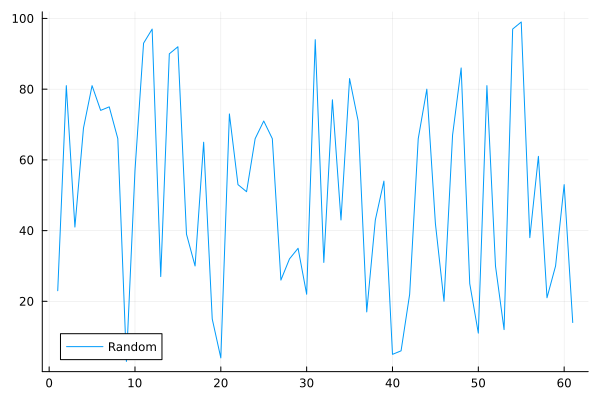

In [54]:
plot(index, action_list, label="Random")
# plot!(index, action_list_mcts, title="Actions with MCTS", label="MCTS")


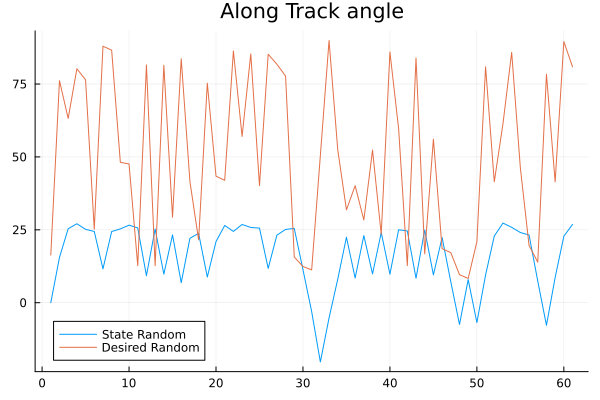

In [92]:
# plot(index, [y_angle_list, y_angle_list_mcts], label=["Random" "With MCTS"], title="Y angle")
plot(index, [y_angle_list, along_ang_des], label=["State Random" "Desired Random"], title="Along Track angle")
# plot(index, along_ang_des, label="Desired Random", title="Along Track angle")

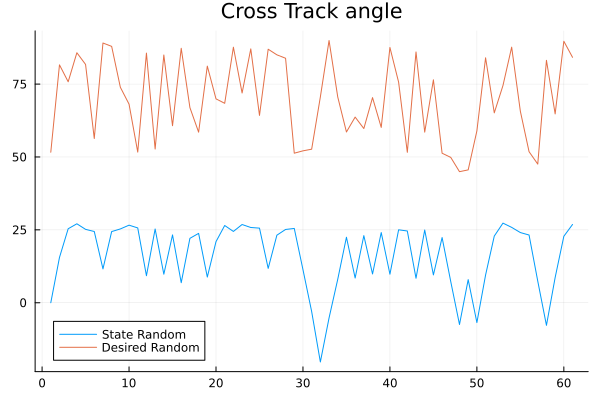

In [93]:
# plot(index, [x_angle_list, x_angle_list_mcts], label=["Random" "With MCTS"], title="X angle")
plot(index, [y_angle_list, cross_ang_des], label=["State Random" "Desired Random"], title="Cross Track angle")

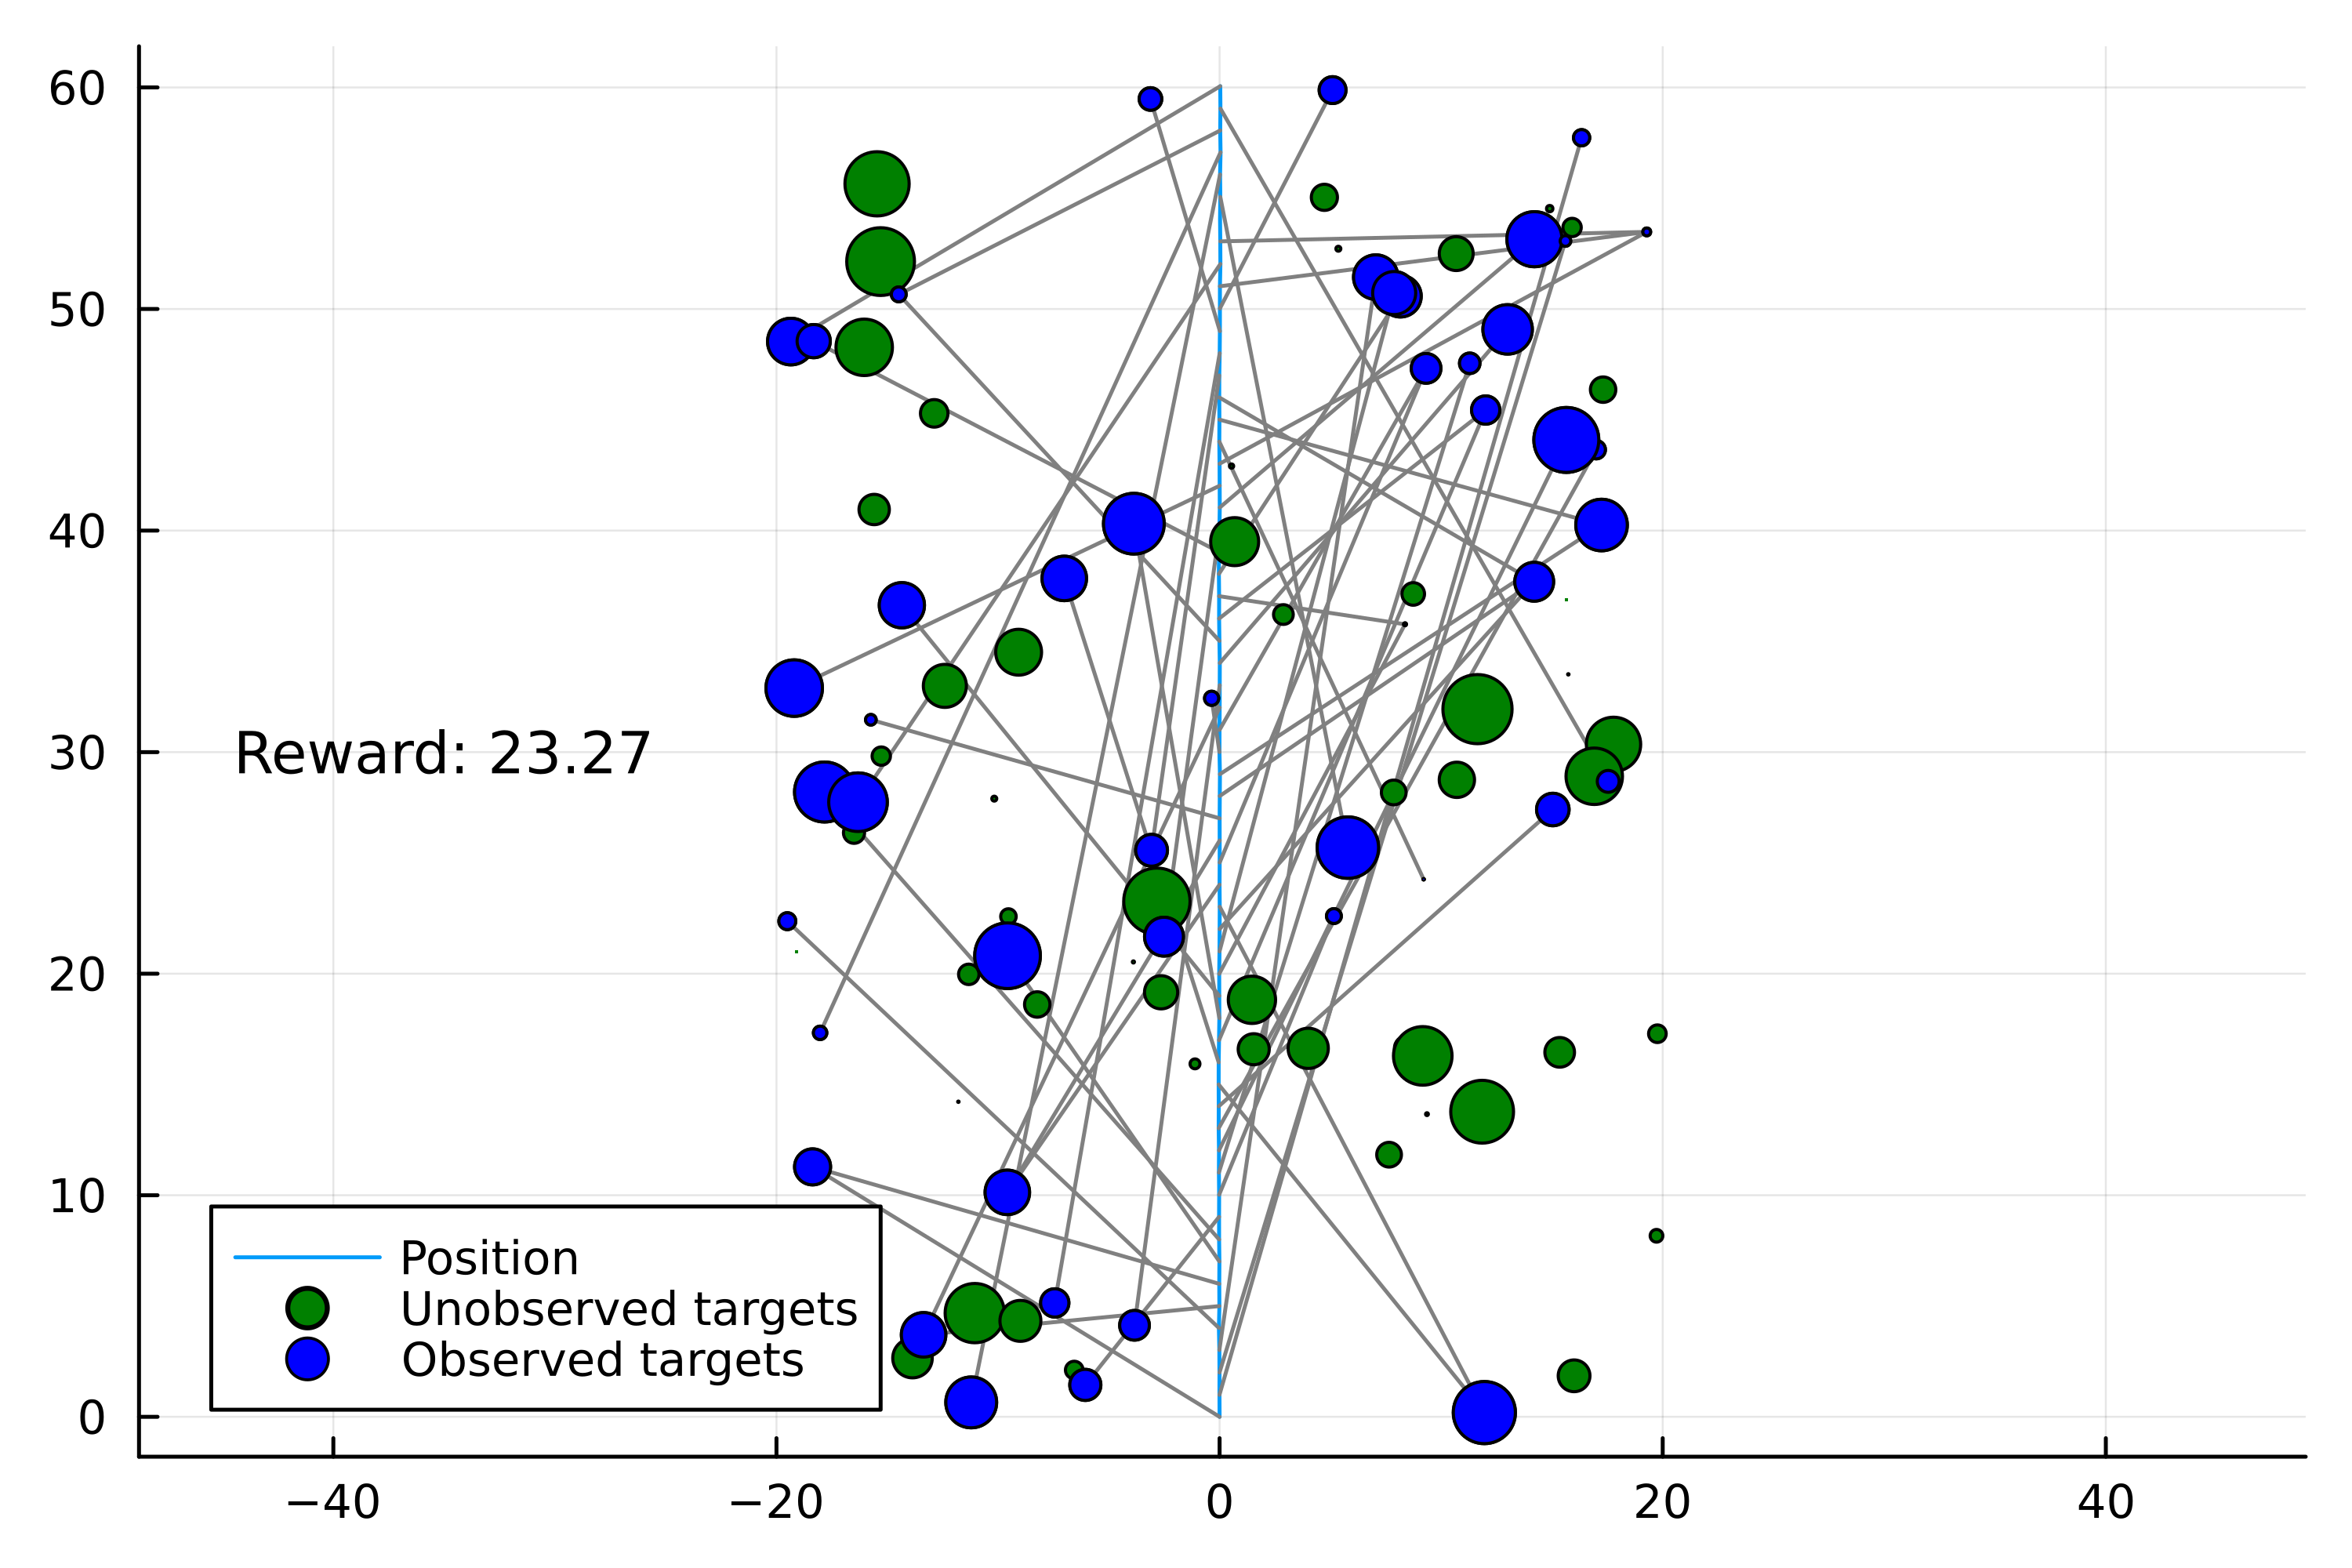

"/home/gigavoltflash/stanford_classes/AA_228/AA228-Final-Project/dev-anshuk/random_targeting.png"

In [ ]:
plt = plot(x_list, y_list, label="Position", aspect_ratio=:equal, legend=:bottomleft, dpi=500)

for i in 1:length(x_list)
    if action_list[i] != 1
        plot!([x_list[i], target_x_r[action_list[i] - 1]], [y_list[i], target_y_r[action_list[i] - 1]], label="", c="gray")
    end
end

reward_round = round(reward_total, digits=2)
text_to_display = "Reward: $reward_round"
annotate!((-35, 30, text(text_to_display, 10, :left, :center, :black)))


scatter!(target_x_r,target_y_r, mc="green", label="Unobserved targets", markersize = 10*target_reward_r)
scatter!(observed_target_x_r,observed_target_y_r, mc="blue", label="Observed targets", markersize = 10*observed_target_reward_r)
display(plt)

savefig(plt, "random_targeting.png")


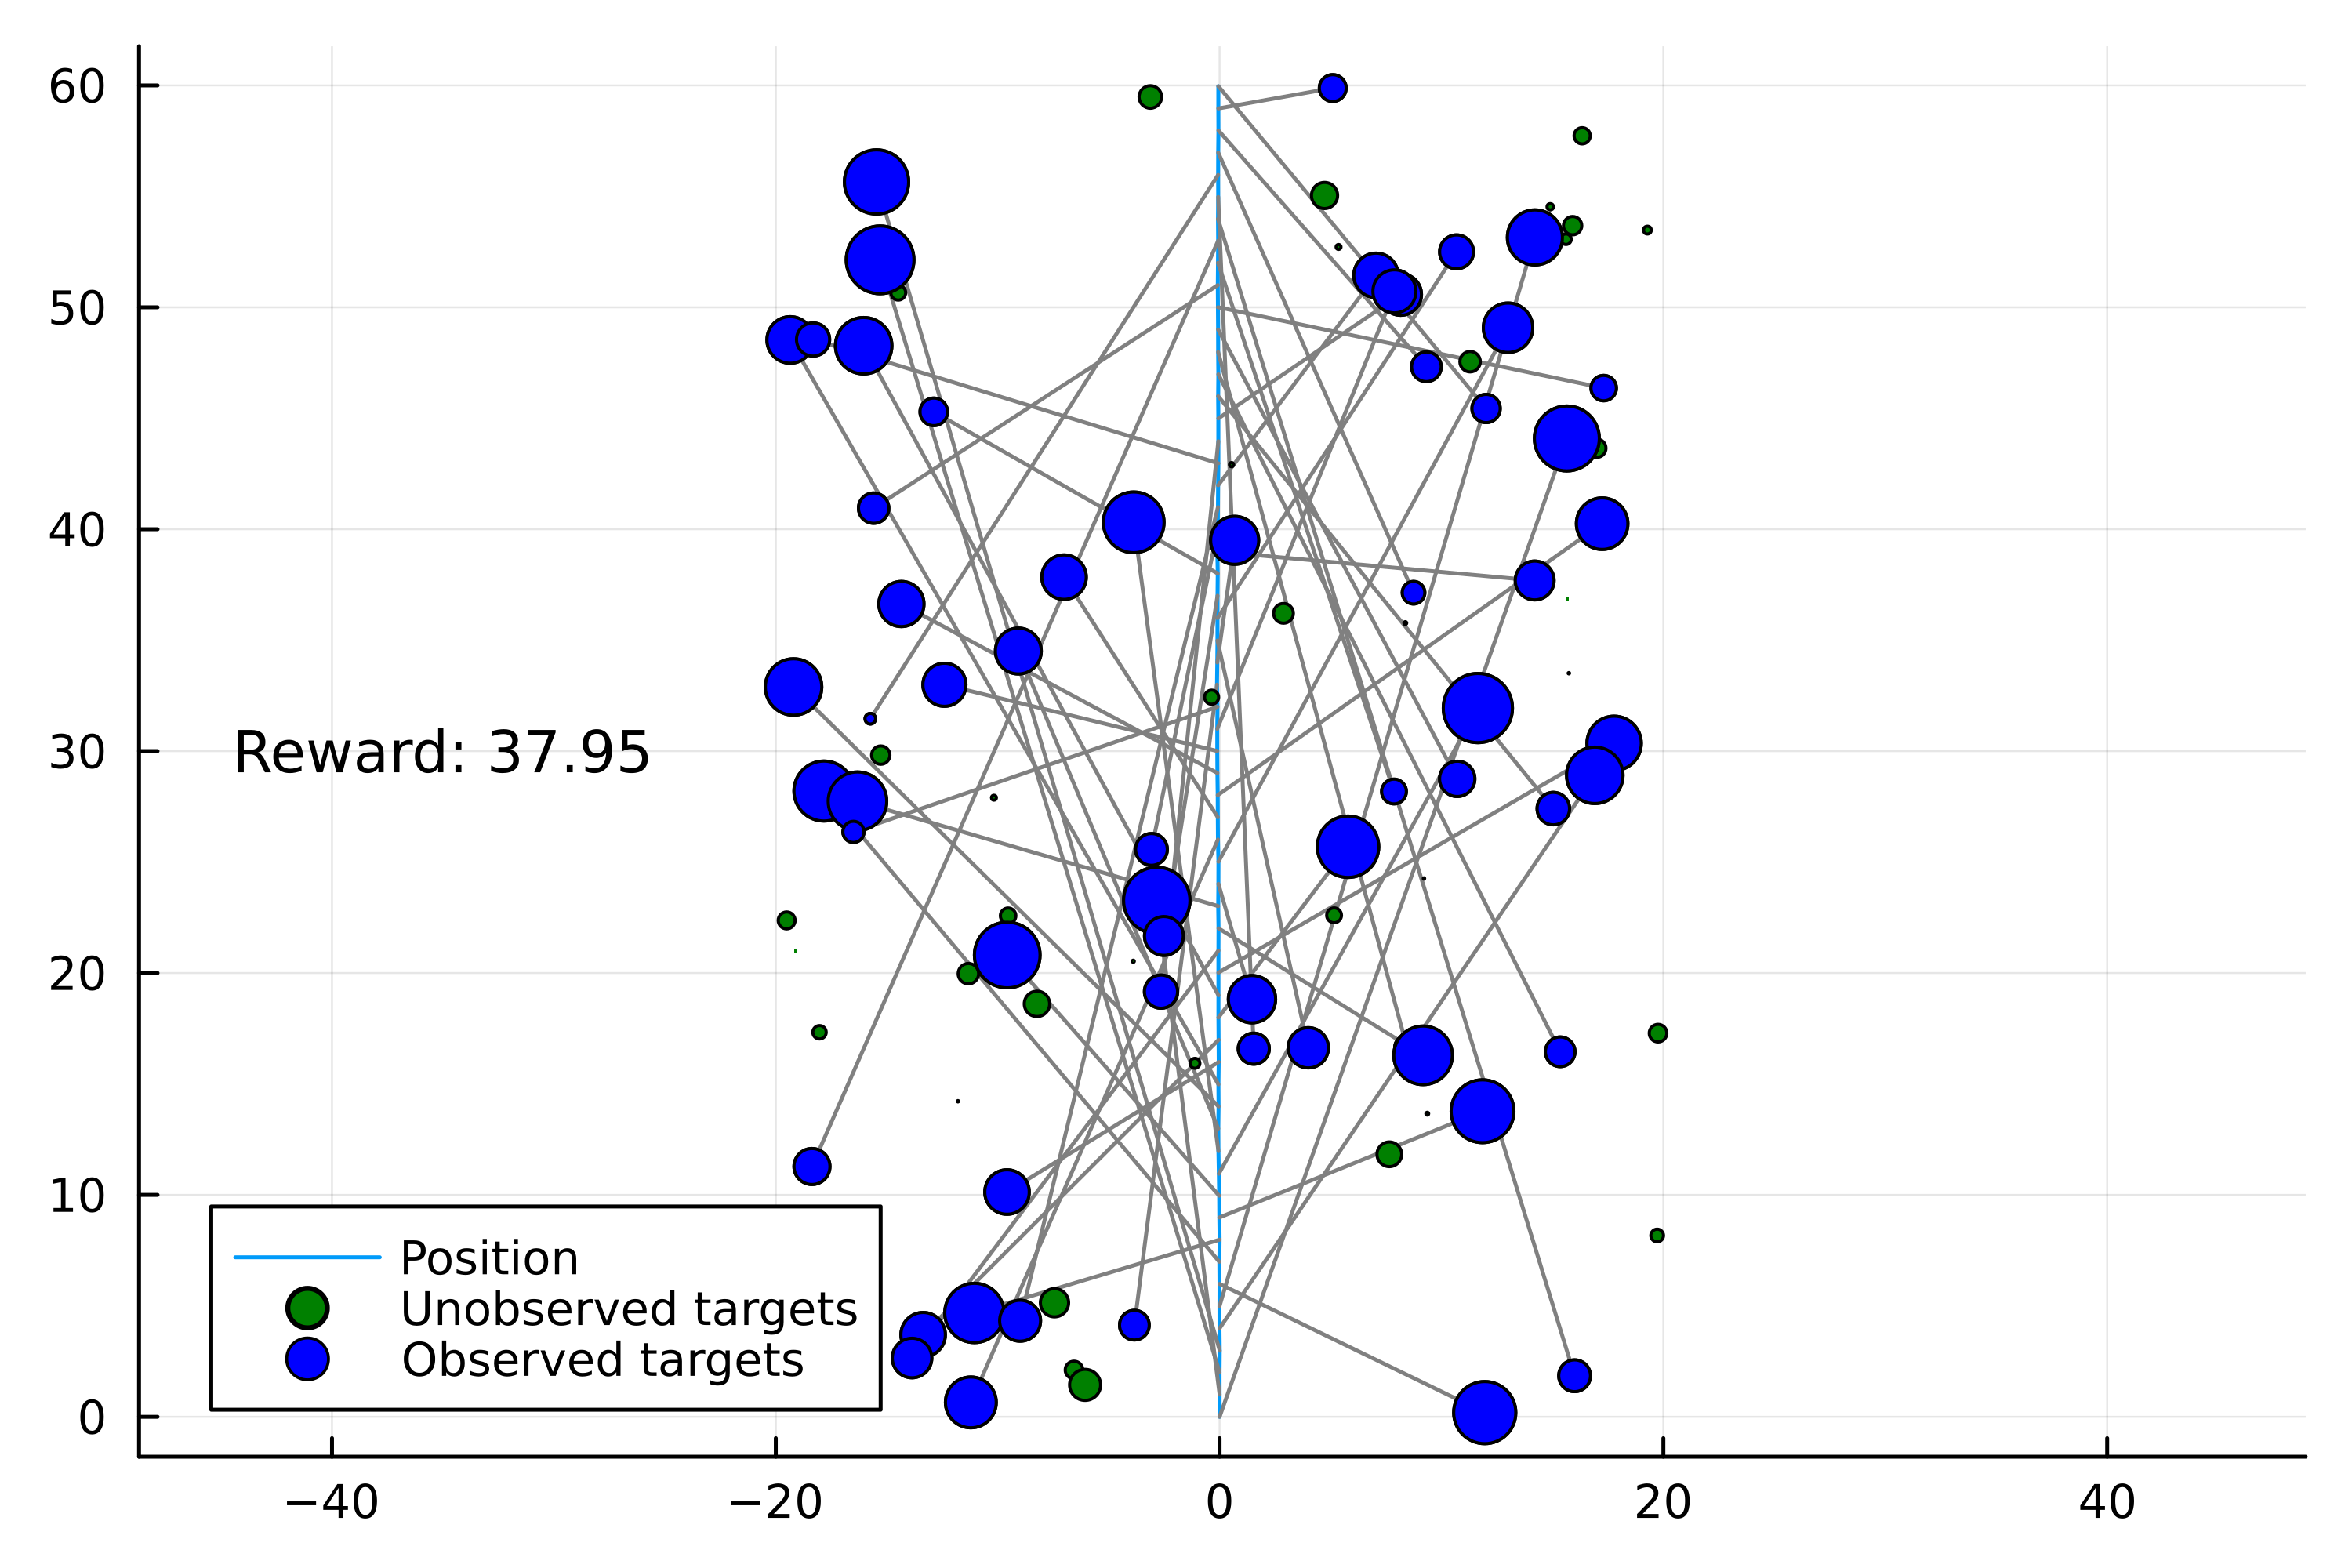

"/home/gigavoltflash/stanford_classes/AA_228/AA228-Final-Project/dev-anshuk/mcts_targeting.png"

In [ ]:
plt = plot(x_list_mcts, y_list_mcts, label="Position", aspect_ratio=:equal, legend=:bottomleft, dpi=500)

for i in 1:length(x_list_mcts)
    if action_list_mcts[i] != 1
        plot!([x_list_mcts[i], target_x[action_list_mcts[i] - 1]], [y_list_mcts[i], target_y[action_list_mcts[i] - 1]], label="", c="gray")
    end
end

reward_mcts_round = round(reward_total_mcts, digits=2)
text_to_display = "Reward: $reward_mcts_round"
annotate!((-35, 30, text(text_to_display, 10, :left, :center, :black)))

scatter!(target_x,target_y, mc="green", label="Unobserved targets", markersize = 10*target_reward)
scatter!(observed_target_x,observed_target_y, mc="blue", label="Observed targets", markersize = 10*observed_target_reward)

display(plt)
savefig(plt, "mcts_targeting.png")